# Experiments

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from lightgbm import LGBMClassifier

from CustomFunctions import classification_report_IDS
from CustomFunctions import Timer

from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss

TRAINING_SET = 'Inputs\\train_test_sets\\training.csv'
TESTING_SET = 'Inputs\\train_test_sets\\testing.csv'

### Load Training and Testing datasets

In [4]:
#Load all training data
X_train = pd.read_csv(TRAINING_SET)
y_train = X_train.pop('Label')
print(X_train.shape)

#Load all testing data
X_test = pd.read_csv(TESTING_SET)
y_test = X_test.pop('Label')
print(X_test.shape)

(999856, 71)
(1499016, 71)


In [5]:
print('Shape of Training Set:', X_train.shape)
print('Shape of Testing Set:', X_test.shape)
dist = pd.DataFrame()
dist['y_train Freq'] = y_train.value_counts()
dist['y_train %'] = y_train.value_counts(normalize=True)
dist['y_test Freq'] = y_test.value_counts()
dist['y_test %'] = y_test.value_counts(normalize=True)
dist.style.format("{:.3%}", subset=['y_train %', 'y_test %'])

Shape of Training Set: (999856, 71)
Shape of Testing Set: (1499016, 71)


,y_train Freq,y_train %,y_test Freq,y_test %
Label,,,,
DoS attacks-Hulk,164962,16.499%,115478,7.704%
DDOS attack-HOIC,156456,15.648%,171503,11.441%
DDoS attacks-LOIC-HTTP,151250,15.127%,144048,9.610%
Bot,129813,12.983%,71548,4.773%
Benign,121965,12.198%,847255,56.521%
Infilteration,120476,12.049%,40160,2.679%
SSH-Bruteforce,84521,8.453%,46897,3.129%
DoS attacks-GoldenEye,31131,3.114%,10377,0.692%
FTP-BruteForce,29045,2.905%,48339,3.225%


### Dataset Balancing

Given the dataset is highly unbalanced, we need to evaluate the impact of this and what strategies we can use to get the best out of the LightGBM classifier. First, we'll assess what would be the impact if not using any balancing strategy at all

#### Training using the unbalanced dataset

In [6]:
X_train.shape

(999856, 71)

In [7]:
#drop features that are not required
features_to_drop = ['Protocol', 'Dst Port Class']
X_train.drop(axis=1, columns=features_to_drop, inplace=True)
X_test.drop(axis=1, columns=features_to_drop, inplace=True)

#Encode the target classes
labelEnc = LabelEncoder()
y_train = pd.Series(labelEnc.fit_transform(y_train), index=y_train.index)
y_test =  pd.Series(labelEnc.fit_transform(y_test), index=y_test.index)

#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train, y_train)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))


Training Set: Size:  (999856, 69)
Training Set: F2 score:  0.10188472315404686
Training Set: Matthews Correlation Coefficient:  0.11621397125840015

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.08699970071559517
Testing Set: Matthews Correlation Coefficient:  0.03396310213985546


#### Training using an unbalanced dataset - Just using Class Weights on Classifier

In [9]:
#define the classifier
clf = LGBMClassifier(class_weight='balanced', objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train, y_train)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))


Training Set: Size:  (999856, 69)
Training Set: F2 score:  0.9782897110451056
Training Set: Matthews Correlation Coefficient:  0.9765964478000423

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8818881025411921
Testing Set: Matthews Correlation Coefficient:  0.9075697660210742


    precision  recall  f2-score  support
0        1.00    0.88      0.90  847,255
1        1.00    1.00      1.00   71,548
2        0.13    0.95      0.42      153
3        0.77    0.93      0.89       57
4        1.00    1.00      1.00  171,503
5        0.76    0.98      0.93      432
6        1.00    1.00      1.00  144,048
7        1.00    1.00      1.00   10,377
8        1.00    1.00      1.00  115,478
9        0.99    1.00      1.00    2,747
10       1.00    1.00      1.00   48,339
11       0.28    0.93      0.63   40,160
12       0.26    0.82      0.57       22
13       1.00    1.00      1.00   46,897

Matthews Correlation Coefficient:  0.91
F2 Macro score:  88.2%
None


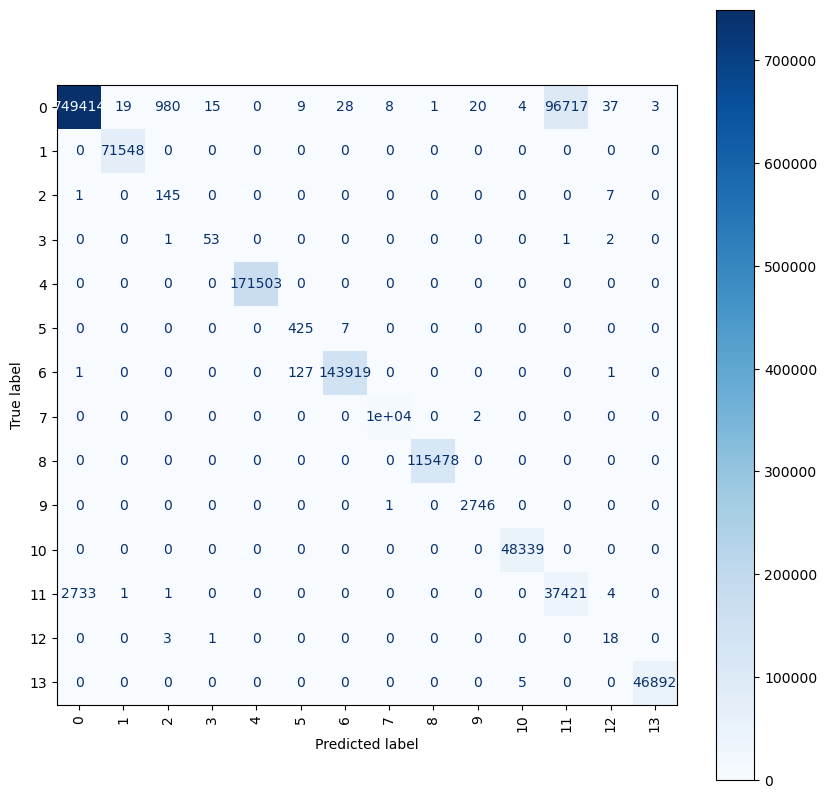

In [10]:
#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
cReport = classification_report_IDS(y_test, pred_test)
print(cReport)

#### Training after balancing dataset - RandomUnderSampler and RandomOverSampler

In [11]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [12]:
#Define the over sampling and under sampling ratios
dictUnderSample = {  8: 50000,
                    4: 50000,
                    6: 50000,
                    1: 50000,
                    0: 50000,
                    11: 50000,
                    13: 50000,
                    7: 31131,
                    10: 29045,
                    9: 8243,
                    5: 1298,
                    2: 458,
                    3: 173,
                    12: 65}

dictOverSample = {  8: 50000,
                    4: 50000,
                    6: 50000,
                    1: 50000,
                    0: 50000,
                    11: 50000,
                    13: 50000,
                    7: 50000,
                    10: 50000,
                    9: 50000,
                    5: 50000,
                    2: 50000,
                    3: 50000,
                    12: 50000}

pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', RandomOverSampler(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)

In [13]:
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
13    50000
Name: count, dtype: int64

In [14]:
#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))


Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9858786118969656
Training Set: Matthews Correlation Coefficient:  0.9848306331684265

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.9037705527050672
Testing Set: Matthews Correlation Coefficient:  0.9014379101484135


#### Training after balancing dataset - Nearmiss and SMOTE

In [143]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [145]:
#Undersample and the oversample
pipeline = Pipeline(steps=[ ('underSample', NearMiss(version=2, sampling_strategy=dictUnderSample)),
                            ('overSample', SMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
13    50000
Name: count, dtype: int64

In [146]:
#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))



Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9851208580046416
Training Set: Matthews Correlation Coefficient:  0.9841996432234474

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.6880689797513871
Testing Set: Matthews Correlation Coefficient:  0.7687052648540399


#### Training after balancing dataset - RandomUnderSampler and SMOTE

In [147]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [148]:
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', SMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
13    50000
Name: count, dtype: int64

In [149]:
#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Train the classifier
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2_Macro score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2_Macro score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (700000, 69)
Training Set: F2_Macro score:  0.9854879107057679
Training Set: Matthews Correlation Coefficient:  0.9844036283536937

Testing Set: Size:  (1499016, 69)
Testing Set: F2_Macro score:  0.8887335827485824
Testing Set: Matthews Correlation Coefficient:  0.9027174066846889




#### Training after balancing dataset - RandomUnderSampler and BorderlineSMOTE

In [150]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [156]:
#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
11    50000
12    50000
13    50000
10    29045
Name: count, dtype: int64

In [157]:
#Define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (679045, 69)
Training Set: F2 score:  0.9822112087477219
Training Set: Matthews Correlation Coefficient:  0.9802750522462694

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.9101498165506738
Testing Set: Matthews Correlation Coefficient:  0.9040854097498818




#### Training after balancing dataset - NearMiss (ver1) and BorderlineSMOTE

In [158]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [159]:
#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', NearMiss(version=1, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
11    50000
12    50000
13    50000
10    29045
Name: count, dtype: int64

In [162]:
#Define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Train the classifier
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (679045, 69)
Training Set: F2 score:  0.40008735326440814
Training Set: Matthews Correlation Coefficient:  0.41343387964378053

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.3110688607848441
Testing Set: Matthews Correlation Coefficient:  0.3017623143131098




#### Training after balancing dataset - NearMiss (ver2) and BorderlineSMOTE

In [163]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [164]:
#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', NearMiss(version=2, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
11    50000
12    50000
13    50000
10    29045
Name: count, dtype: int64

In [165]:
#Define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (679045, 69)
Training Set: F2 score:  0.9823469575821839
Training Set: Matthews Correlation Coefficient:  0.9806460073280666

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.6041997539547443
Testing Set: Matthews Correlation Coefficient:  0.6309059927393734




#### Training after partially balancing dataset - RandomUnderSampler and Class Weights on classifier

In [166]:
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [168]:
#Undersample with RandomUnderSampler 
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample))])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
4     50000
6     50000
8     50000
11    50000
13    50000
7     31131
10    29045
9      8243
5      1298
2       458
3       173
12       65
Name: count, dtype: int64

In [169]:
#Define the classifier
clf = LGBMClassifier(objective='multiclass', class_weight='balanced', n_jobs=-1, verbose=-1)
 
#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (420413, 69)
Training Set: F2 score:  0.9826005663535602
Training Set: Matthews Correlation Coefficient:  0.9778416678992875

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8753346371742315
Testing Set: Matthews Correlation Coefficient:  0.9064857136042759




### Preliminary Pricipal Component Analysis

In [9]:
#Undersample with RandomUnderSampler 
requiredCounts = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29041,
                    'DoS attacks-Slowloris': 8242,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}
underSampling = RandomUnderSampler(random_state=0, sampling_strategy=requiredCounts)

# transform the dataset
X_train2, y_train2 = underSampling.fit_resample(X_train, y_train)
y_train2.value_counts()

Label
Benign                    50000
Bot                       50000
DDOS attack-HOIC          50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-Hulk          50000
Infilteration             50000
SSH-Bruteforce            50000
DoS attacks-GoldenEye     31131
FTP-BruteForce            29041
DoS attacks-Slowloris      8242
DDOS attack-LOIC-UDP       1298
Brute Force -Web            458
Brute Force -XSS            173
SQL Injection                65
Name: count, dtype: int64

In [10]:
requiredCounts = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 50000,
                    'FTP-BruteForce': 50000,
                    'DoS attacks-Slowloris': 50000,
                    'DDOS attack-LOIC-UDP': 50000,
                    'Brute Force -Web': 50000,
                    'Brute Force -XSS': 50000,
                    'SQL Injection': 50000}

overSampling = RandomOverSampler(sampling_strategy=requiredCounts)
X_train2, y_train2 = overSampling.fit_resample(X_train2, y_train2)
y_train2.value_counts()

Label
Benign                    50000
Bot                       50000
Brute Force -Web          50000
Brute Force -XSS          50000
DDOS attack-HOIC          50000
DDOS attack-LOIC-UDP      50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-GoldenEye     50000
DoS attacks-Hulk          50000
DoS attacks-Slowloris     50000
FTP-BruteForce            50000
Infilteration             50000
SQL Injection             50000
SSH-Bruteforce            50000
Name: count, dtype: int64

In [11]:
#define pipeline
workflowPipe = Pipeline(steps=[
                            ('scale',  StandardScaler()),   #PCA requires the data to be scaled 
                            ('pca', PCA(0.99)),
                            ('classifier', LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1))
                        ])

#Run the pipeline
workflowPipe.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = workflowPipe.predict(X_train2)
pred_test = workflowPipe.predict(X_test)

#Output results
print('Number of features before PCA: ', len(X_train2.columns))
print('Number of components after PCA: ', workflowPipe['pca'].n_components_)
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')


Number of features before PCA:  71
Number of components after PCA:  28

Training Set: Size:  (700000, 71)
Training Set: F2 score:  0.9818593958978089
Training Set: Matthews Correlation Coefficient:  0.9804745180682491

Testing Set: Size:  (1499016, 71)
Testing Set: F2 score:  0.8733618388726471
Testing Set: Matthews Correlation Coefficient:  0.8832397761037399




In [77]:
#define pipeline
workflowPipe = Pipeline(steps=[
                            ('scale',  StandardScaler()),
                            ('pca', PCA(0.90)),
                            ('classifier', LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1))
                        ])

#Run the pipeline
workflowPipe.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = workflowPipe.predict(X_train2)
pred_test = workflowPipe.predict(X_test)

#Output results
print('Number of features before PCA: ', len(X_train2.columns))
print('Number of components after PCA: ', workflowPipe['pca'].n_components_)
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')


Number of features before PCA:  69
Number of components after PCA:  16

Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9774067116127905
Training Set: Matthews Correlation Coefficient:  0.9756907003845612

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8517773634435407
Testing Set: Matthews Correlation Coefficient:  0.8820157229957106




## SHAP analysis

In [4]:
#Define the over sampling and under sampling dictionaries
dictUnderSample = { 'DoS attacks-Hulk': 20000,
                    'DDOS attack-HOIC': 20000,
                    'DDoS attacks-LOIC-HTTP': 20000,
                    'Bot': 20000,
                    'Benign': 20000,
                    'Infilteration': 20000,
                    'SSH-Bruteforce': 20000,
                    'DoS attacks-GoldenEye': 20000,
                    'FTP-BruteForce': 20000,
                    'DoS attacks-Slowloris': 8243,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}

dictOverSample = {  'DoS attacks-Hulk': 20000,
                    'DDOS attack-HOIC': 20000,
                    'DDoS attacks-LOIC-HTTP': 20000,
                    'Bot': 20000,
                    'Benign': 20000,
                    'Infilteration': 20000,
                    'SSH-Bruteforce': 20000,
                    'DoS attacks-GoldenEye': 20000,
                    'FTP-BruteForce': 20000,
                    'DoS attacks-Slowloris': 20000,
                    'DDOS attack-LOIC-UDP': 20000,
                    'Brute Force -Web': 20000,
                    'Brute Force -XSS': 20000,
                    'SQL Injection': 20000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

280000


Label
Benign                    20000
Bot                       20000
Brute Force -Web          20000
Brute Force -XSS          20000
DDOS attack-HOIC          20000
DDOS attack-LOIC-UDP      20000
DDoS attacks-LOIC-HTTP    20000
DoS attacks-GoldenEye     20000
DoS attacks-Hulk          20000
DoS attacks-Slowloris     20000
FTP-BruteForce            20000
Infilteration             20000
SQL Injection             20000
SSH-Bruteforce            20000
Name: count, dtype: int64

In [5]:
clf = LGBMClassifier(boosting_type='gbdt', objective='multiclass', n_jobs=-1, verbose=-1,
                     n_estimators=100, num_leaves=152, learning_rate=0.1158, max_bin=400,
                    bagging_fraction=0.807, bagging_freq=0)

#First fit the model
clf.fit(X_train2, y_train2)


c:\Users\Delan\anaconda\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


LGBMClassifier(bagging_fraction=0.807, bagging_freq=0, learning_rate=0.1158,
               max_bin=400, n_jobs=-1, num_leaves=152, objective='multiclass',
               verbose=-1)

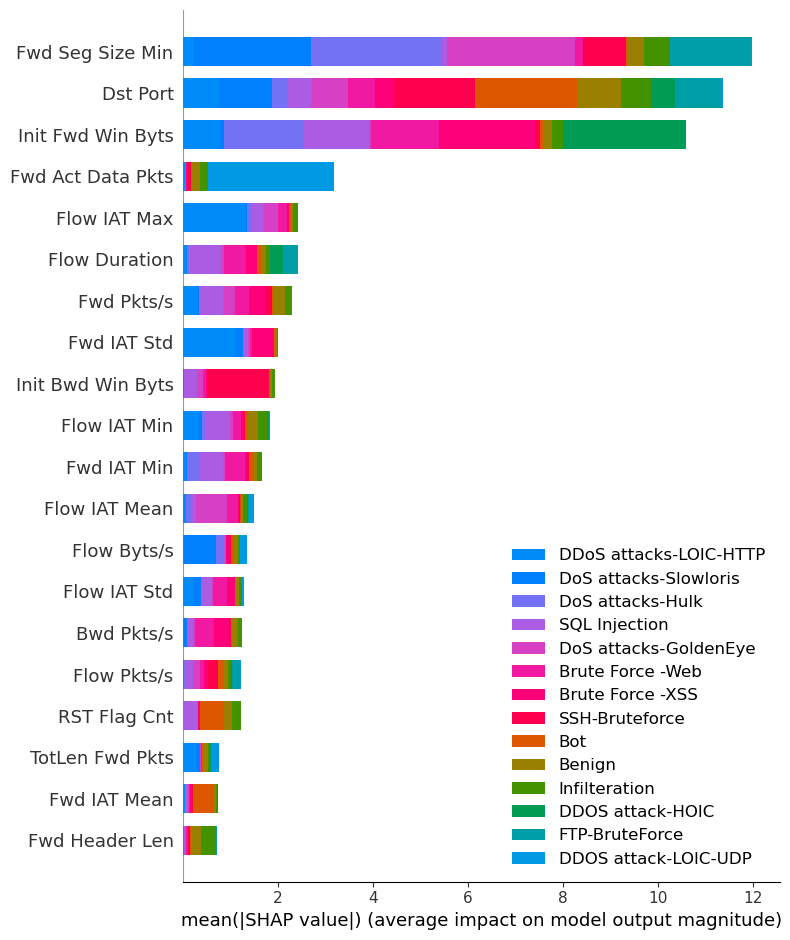

In [28]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_train2)

classNames = np.sort(y_train2.unique()).tolist()
shap.summary_plot(shap_values, X_train2, class_names=classNames)

In [29]:
#Save shap values to a file
np.save('ShapValues', shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


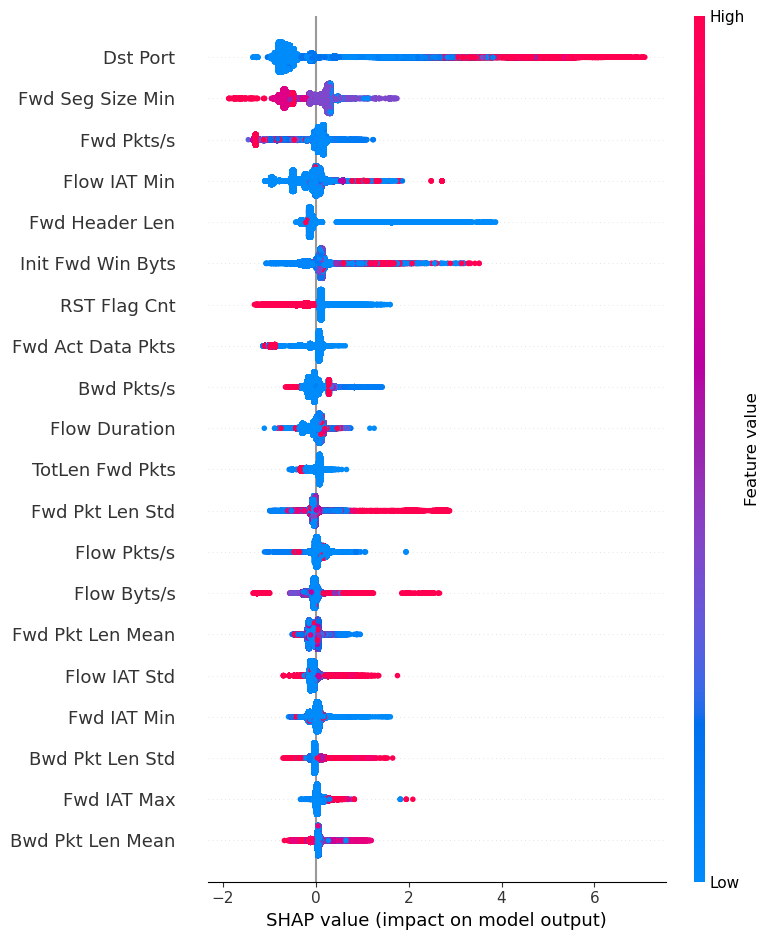

In [35]:
shap.summary_plot(shap_values[0], X_train2, class_names=classNames)

In [34]:
#Examine the SHAP values for the first class
shap_df0 = pd.DataFrame(shap_values[0], columns=X_train2.columns)
shap_df0

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Dst Port Class
0,4.608739,0.0,-0.271427,0.013419,0.004219,0.197467,0.018134,0.072171,0.003191,0.582377,...,0.341658,0.000826,0.001204,-0.001601,-0.000413,0.001609,0.004329,0.018048,-0.002295,0.000311
1,5.224453,0.0,0.101574,0.005141,0.003575,0.087990,-0.000426,1.124578,0.000854,0.013185,...,0.048840,0.001454,0.002689,0.000228,0.000775,0.000941,0.008812,0.008949,0.001240,0.000174
2,6.050561,0.0,0.066736,0.005617,0.002921,0.071434,0.023859,0.037429,0.007210,0.014390,...,0.269966,-0.000216,0.002957,0.001830,-0.000863,0.002285,0.005475,0.012144,0.000204,0.000405
3,5.152581,0.0,0.073982,0.007984,0.003526,0.085489,0.004014,1.109334,0.005959,-0.005473,...,0.050062,0.001276,0.002693,-0.000156,0.000745,0.001078,0.009214,0.009334,0.001402,0.000174
4,4.466252,0.0,0.180234,0.037097,-0.000125,0.092686,0.013055,0.015645,0.004796,0.010288,...,0.131977,-0.003778,0.000101,0.000081,-0.009082,0.090067,0.030557,0.156685,-0.116737,0.000293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279995,-0.876068,0.0,-0.110842,0.008799,0.004332,0.086789,0.014993,-0.007043,0.003127,-0.139517,...,0.209661,0.001004,0.001093,-0.001827,-0.000147,0.006069,0.005362,0.021763,0.005568,-0.000139
279996,-0.863335,0.0,-0.092833,0.008772,0.004317,0.086956,0.014796,-0.006899,0.003152,-0.139072,...,0.209502,0.000986,0.001153,-0.001867,-0.000148,0.006023,0.005337,0.021744,0.005538,-0.000139
279997,-0.514856,0.0,0.109405,0.036596,0.001911,0.052606,0.013709,0.033979,0.005603,-0.099976,...,0.220008,-0.007126,0.003181,0.000065,-0.000847,0.005549,0.006516,0.015197,0.002867,-0.000022
279998,-0.672292,0.0,0.117658,0.019374,-0.002990,0.095078,0.019553,0.002681,0.001985,-0.100148,...,0.057577,-0.002035,0.001268,-0.001934,-0.000374,0.005583,0.006997,0.019397,0.004057,-0.000127


In [36]:
shap_df0 = shap_df0.apply(np.abs).mean().sort_values(ascending=False)

In [40]:
#Create dataframes of SHAP values - one for each class
shap_df1 = pd.DataFrame(shap_values[1], columns=X_train2.columns)
shap_df2 = pd.DataFrame(shap_values[2], columns=X_train2.columns)
shap_df3 = pd.DataFrame(shap_values[3], columns=X_train2.columns)
shap_df4 = pd.DataFrame(shap_values[4], columns=X_train2.columns)
shap_df5 = pd.DataFrame(shap_values[5], columns=X_train2.columns)
shap_df6 = pd.DataFrame(shap_values[6], columns=X_train2.columns)
shap_df7 = pd.DataFrame(shap_values[7], columns=X_train2.columns)
shap_df8 = pd.DataFrame(shap_values[8], columns=X_train2.columns)
shap_df9 = pd.DataFrame(shap_values[9], columns=X_train2.columns)
shap_df10 = pd.DataFrame(shap_values[10], columns=X_train2.columns)
shap_df11 = pd.DataFrame(shap_values[11], columns=X_train2.columns)
shap_df12 = pd.DataFrame(shap_values[12], columns=X_train2.columns)
shap_df13 = pd.DataFrame(shap_values[13], columns=X_train2.columns)

In [41]:
#Get the mean SHAP value for all the data points
shap_df1 = shap_df1.apply(np.abs).mean().sort_values(ascending=False)
shap_df2 = shap_df2.apply(np.abs).mean().sort_values(ascending=False)
shap_df3 = shap_df3.apply(np.abs).mean().sort_values(ascending=False)
shap_df4 = shap_df4.apply(np.abs).mean().sort_values(ascending=False)
shap_df5 = shap_df5.apply(np.abs).mean().sort_values(ascending=False)
shap_df6 = shap_df6.apply(np.abs).mean().sort_values(ascending=False)
shap_df7 = shap_df7.apply(np.abs).mean().sort_values(ascending=False)
shap_df8 = shap_df8.apply(np.abs).mean().sort_values(ascending=False)
shap_df9 = shap_df9.apply(np.abs).mean().sort_values(ascending=False)
shap_df10 = shap_df10.apply(np.abs).mean().sort_values(ascending=False)
shap_df11 = shap_df11.apply(np.abs).mean().sort_values(ascending=False)
shap_df12 = shap_df12.apply(np.abs).mean().sort_values(ascending=False)
shap_df13 = shap_df13.apply(np.abs).mean().sort_values(ascending=False)

In [49]:
#Combine the total of all the SHAP values (so that we can assess which of the features overall have very low importance to the model)
shap_total = shap_df0 + shap_df1 + shap_df2 + shap_df3 + shap_df4 + shap_df5 + shap_df6 + shap_df7 + shap_df8 + shap_df9 + shap_df10 + shap_df11 + shap_df12 + shap_df13

In [50]:
shap_total.sort_values(ascending=False)

Fwd Seg Size Min     11.968176
Dst Port             11.357180
Init Fwd Win Byts    10.595531
Fwd Act Data Pkts     3.175375
Flow IAT Max          2.422232
                       ...    
Fwd Seg Size Avg      0.000000
Subflow Bwd Pkts      0.000000
Subflow Fwd Pkts      0.000000
Bwd Seg Size Avg      0.000000
CWE Flag Count        0.000000
Length: 71, dtype: float64

In [75]:
#Which features have very low importance?
shap_total[shap_total < 0.001]

Bwd Seg Size Avg    0.0
CWE Flag Count      0.0
Fwd Seg Size Avg    0.0
SYN Flag Cnt        0.0
Subflow Bwd Pkts    0.0
Subflow Fwd Pkts    0.0
dtype: float64

In [55]:
#Define the over sampling and under sampling dictionaries
dictUnderSample = { 'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29045,
                    'DoS attacks-Slowloris': 8243,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}

dictOverSample = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 50000,
                    'FTP-BruteForce': 50000,
                    'DoS attacks-Slowloris': 50000,
                    'DDOS attack-LOIC-UDP': 50000,
                    'Brute Force -Web': 50000,
                    'Brute Force -XSS': 50000,
                    'SQL Injection': 50000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

679045


Label
Benign                    50000
Bot                       50000
Brute Force -Web          50000
Brute Force -XSS          50000
DDOS attack-HOIC          50000
DDOS attack-LOIC-UDP      50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-GoldenEye     50000
DoS attacks-Hulk          50000
DoS attacks-Slowloris     50000
Infilteration             50000
SQL Injection             50000
SSH-Bruteforce            50000
FTP-BruteForce            29045
Name: count, dtype: int64

In [77]:
# Create a pipeline with ColumnTransformer to drop columns. Drop all the least important features
features_to_drop = ['Protocol', 'Dst Port Class', 'Bwd Seg Size Avg', 'CWE Flag Count', 'Fwd Seg Size Avg', 'SYN Flag Cnt', 'Subflow Bwd Pkts', 
                    'Subflow Fwd Pkts']


#Define the main workflow pipeline
workflowPipe = Pipeline(steps=[
                            ('preprocessing', ColumnTransformer(transformers=[('column dropper', 'drop', features_to_drop)], remainder='passthrough')),
                            ('classifier', LGBMClassifier(boosting_type='gbdt', objective='multiclass', n_jobs=-1, verbose=-1,
                                                        n_estimators=100, num_leaves=152, learning_rate=0.1158, max_bin=400,
                                                        bagging_fraction=0.807, bagging_freq=0))
                        ])

#Run the pipeline
workflowPipe.fit(X_train2, y_train2)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('column dropper', 'drop',
                                                  ['Protocol', 'Dst Port Class',
                                                   'Bwd Seg Size Avg',
                                                   'CWE Flag Count',
                                                   'Fwd Seg Size Avg',
                                                   'SYN Flag Cnt',
                                                   'Subflow Bwd Pkts',
                                                   'Subflow Fwd Pkts'])])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.807, bagging_freq=0,
                                learning_rate=0.1158, max_bin=400, n_jobs=-1,
                                num_leaves=152, objective='multiclass',
                                verbose=-1))])

In [78]:
#Obtain predictions on the full Training dataset
pred_train = workflowPipe.predict(X_train)

#Obtain predictions on the full Testing dataset
pred_test = workflowPipe.predict(X_test)


Training Set: Size:  (999856, 71)
Training Set: F2 score:  0.9835261623723025
Training Set: Matthews Correlation Coefficient:  0.9805038011616085

Testing Set: Size:  (1499016, 71)
Testing Set: F2 score:  0.9142067882863197
Testing Set: Matthews Correlation Coefficient:  0.9105556798515417


                        precision  recall  f2-score  support
Benign                       1.00    0.89      0.91  847,255
Bot                          1.00    1.00      1.00   71,548
Brute Force -Web             0.36    0.92      0.70      153
Brute Force -XSS             0.79    0.95      0.91       57
DDOS attack-HOIC             1.00    1.00      1.00  171,503
DDOS attack-LOIC-UDP         0.72    0.99      0.92      432
DDoS attacks-LOIC-HTTP       1.00    1.00      1.00  144,048
DoS attacks-GoldenEye        1.00    1.00      1.00   10,377
DoS attacks-Hulk             1.00    1.00      1.00  115,478
DoS attacks-Slowloris        0.99    1.00      1.00    2,747
FTP-BruteForce               1.00  

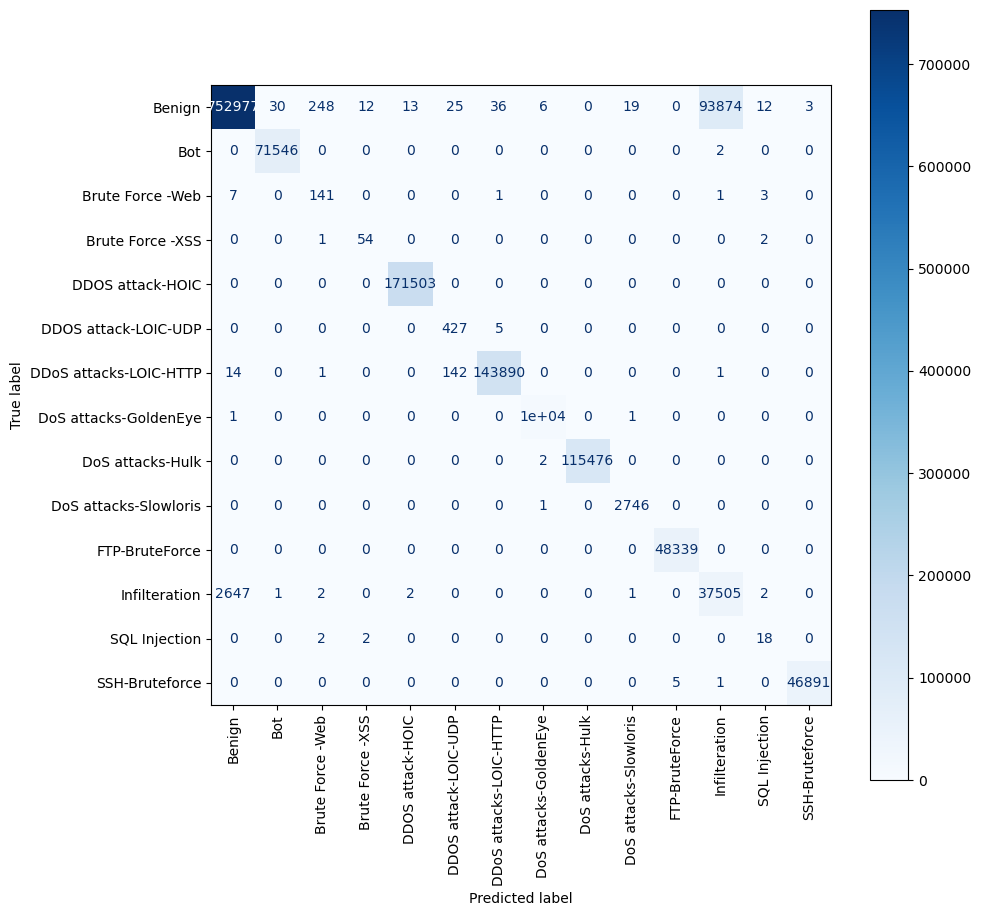

In [79]:

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')

#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=workflowPipe.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
classification_report_IDS(y_test, pred_test)